# Programación declarativa @ URJC
# Programación funcional
## Curso 24-25, convocatoria extraordinaria (12 de junio de 2025)
## Campus de Móstoles/Vicálvaro

La duración del examen es de 1h:20m.

# Preámbulo

In [ ]:
import $ivy.`org.scalatest::scalatest:3.2.16`
import org.scalatest.{Filter => _, _}, flatspec._, matchers._

### Algunas definiciones de tipos y funciones auxiliares

In [ ]:
object Signatures:
    abstract class List[A]:
        
        // Common HOFs
        def foldRight[B](nil: B)(cons: (A, B) => B): B
        def foldLeft[B](initial: B)(update: (B, A) => B): B
        def map[B](f: A => B): List[B]
        def flatMap[B](f: A => List[B]): List[B]
        def filter(f: A => Boolean): List[A]
        def forall(pred: A => Boolean): Boolean
 
        // Common functions
        def length: Int
        def drop(i: Int): List[A]
        def reverse: List[A]
        def flatten[B](/* A debe poder convertirse al tipo List[B] */): List[B]

        // Añade un elemento al final de la lista
        def appended(e: A): List[A]

        // Crea una lista de secuencias de elementos consecutivos de tamaño `n`
        def sliding(n: Int): Iterator[List[A]]

        // Aplica la operación proporcionada como entrada a todos los elementos de la lista
        def reduce(op: (A, A) => A): A


In [ ]:
def iterative_tailrecursion[A, B](l: List[A]): B = 

    def step(out: B, aux: List[A]): B = 
        aux match 
            case Nil => out
            case head :: tail => 
                step(???(out, head), tail)

    step(???, l)

In [ ]:
def iterative_foldLeft[A, B](l: List[A]): B = 
    l.foldLeft[B](???): 
        case (out, head) => 
            ???(out, head)

### Definiciones auxiliares sobre la correspondencia Curry-Howard y Tipos Algebraicos de Datos

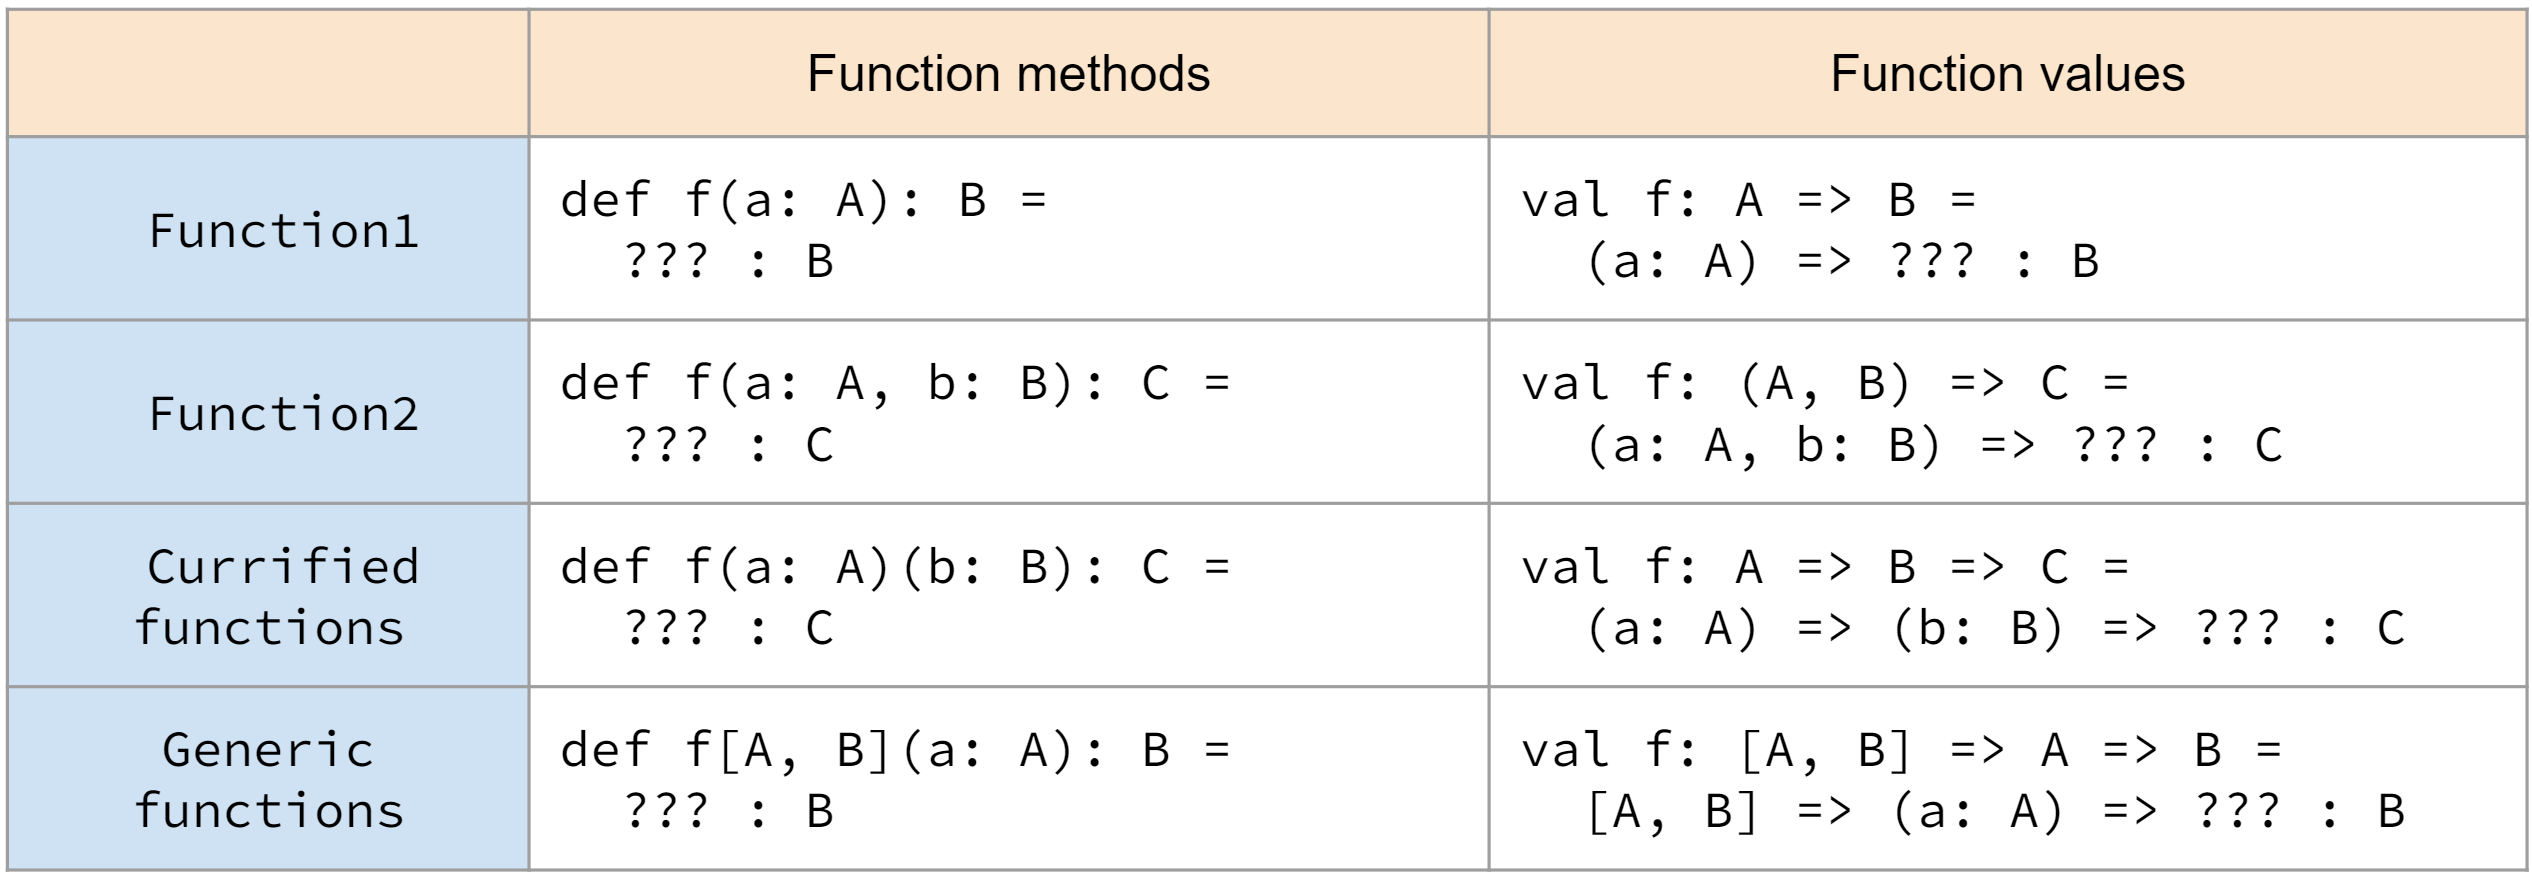

In [ ]:
trait Isomorphic[A, B]:
    
    def from(a: A): B
    
    def to(b: B): A
    
    // equality 
    
    def equalA(a1: A, a2: A): Boolean = 
        a1 == a2
    
    def equalB(b1: B, b2: B): Boolean =
        b1 == b2
    
    // Bijection laws
    
    def law1(a: A): Boolean = 
        equalA(to(from(a)), a)
    
    def law2(b: B): Boolean = 
        equalB(from(to(b)), b)

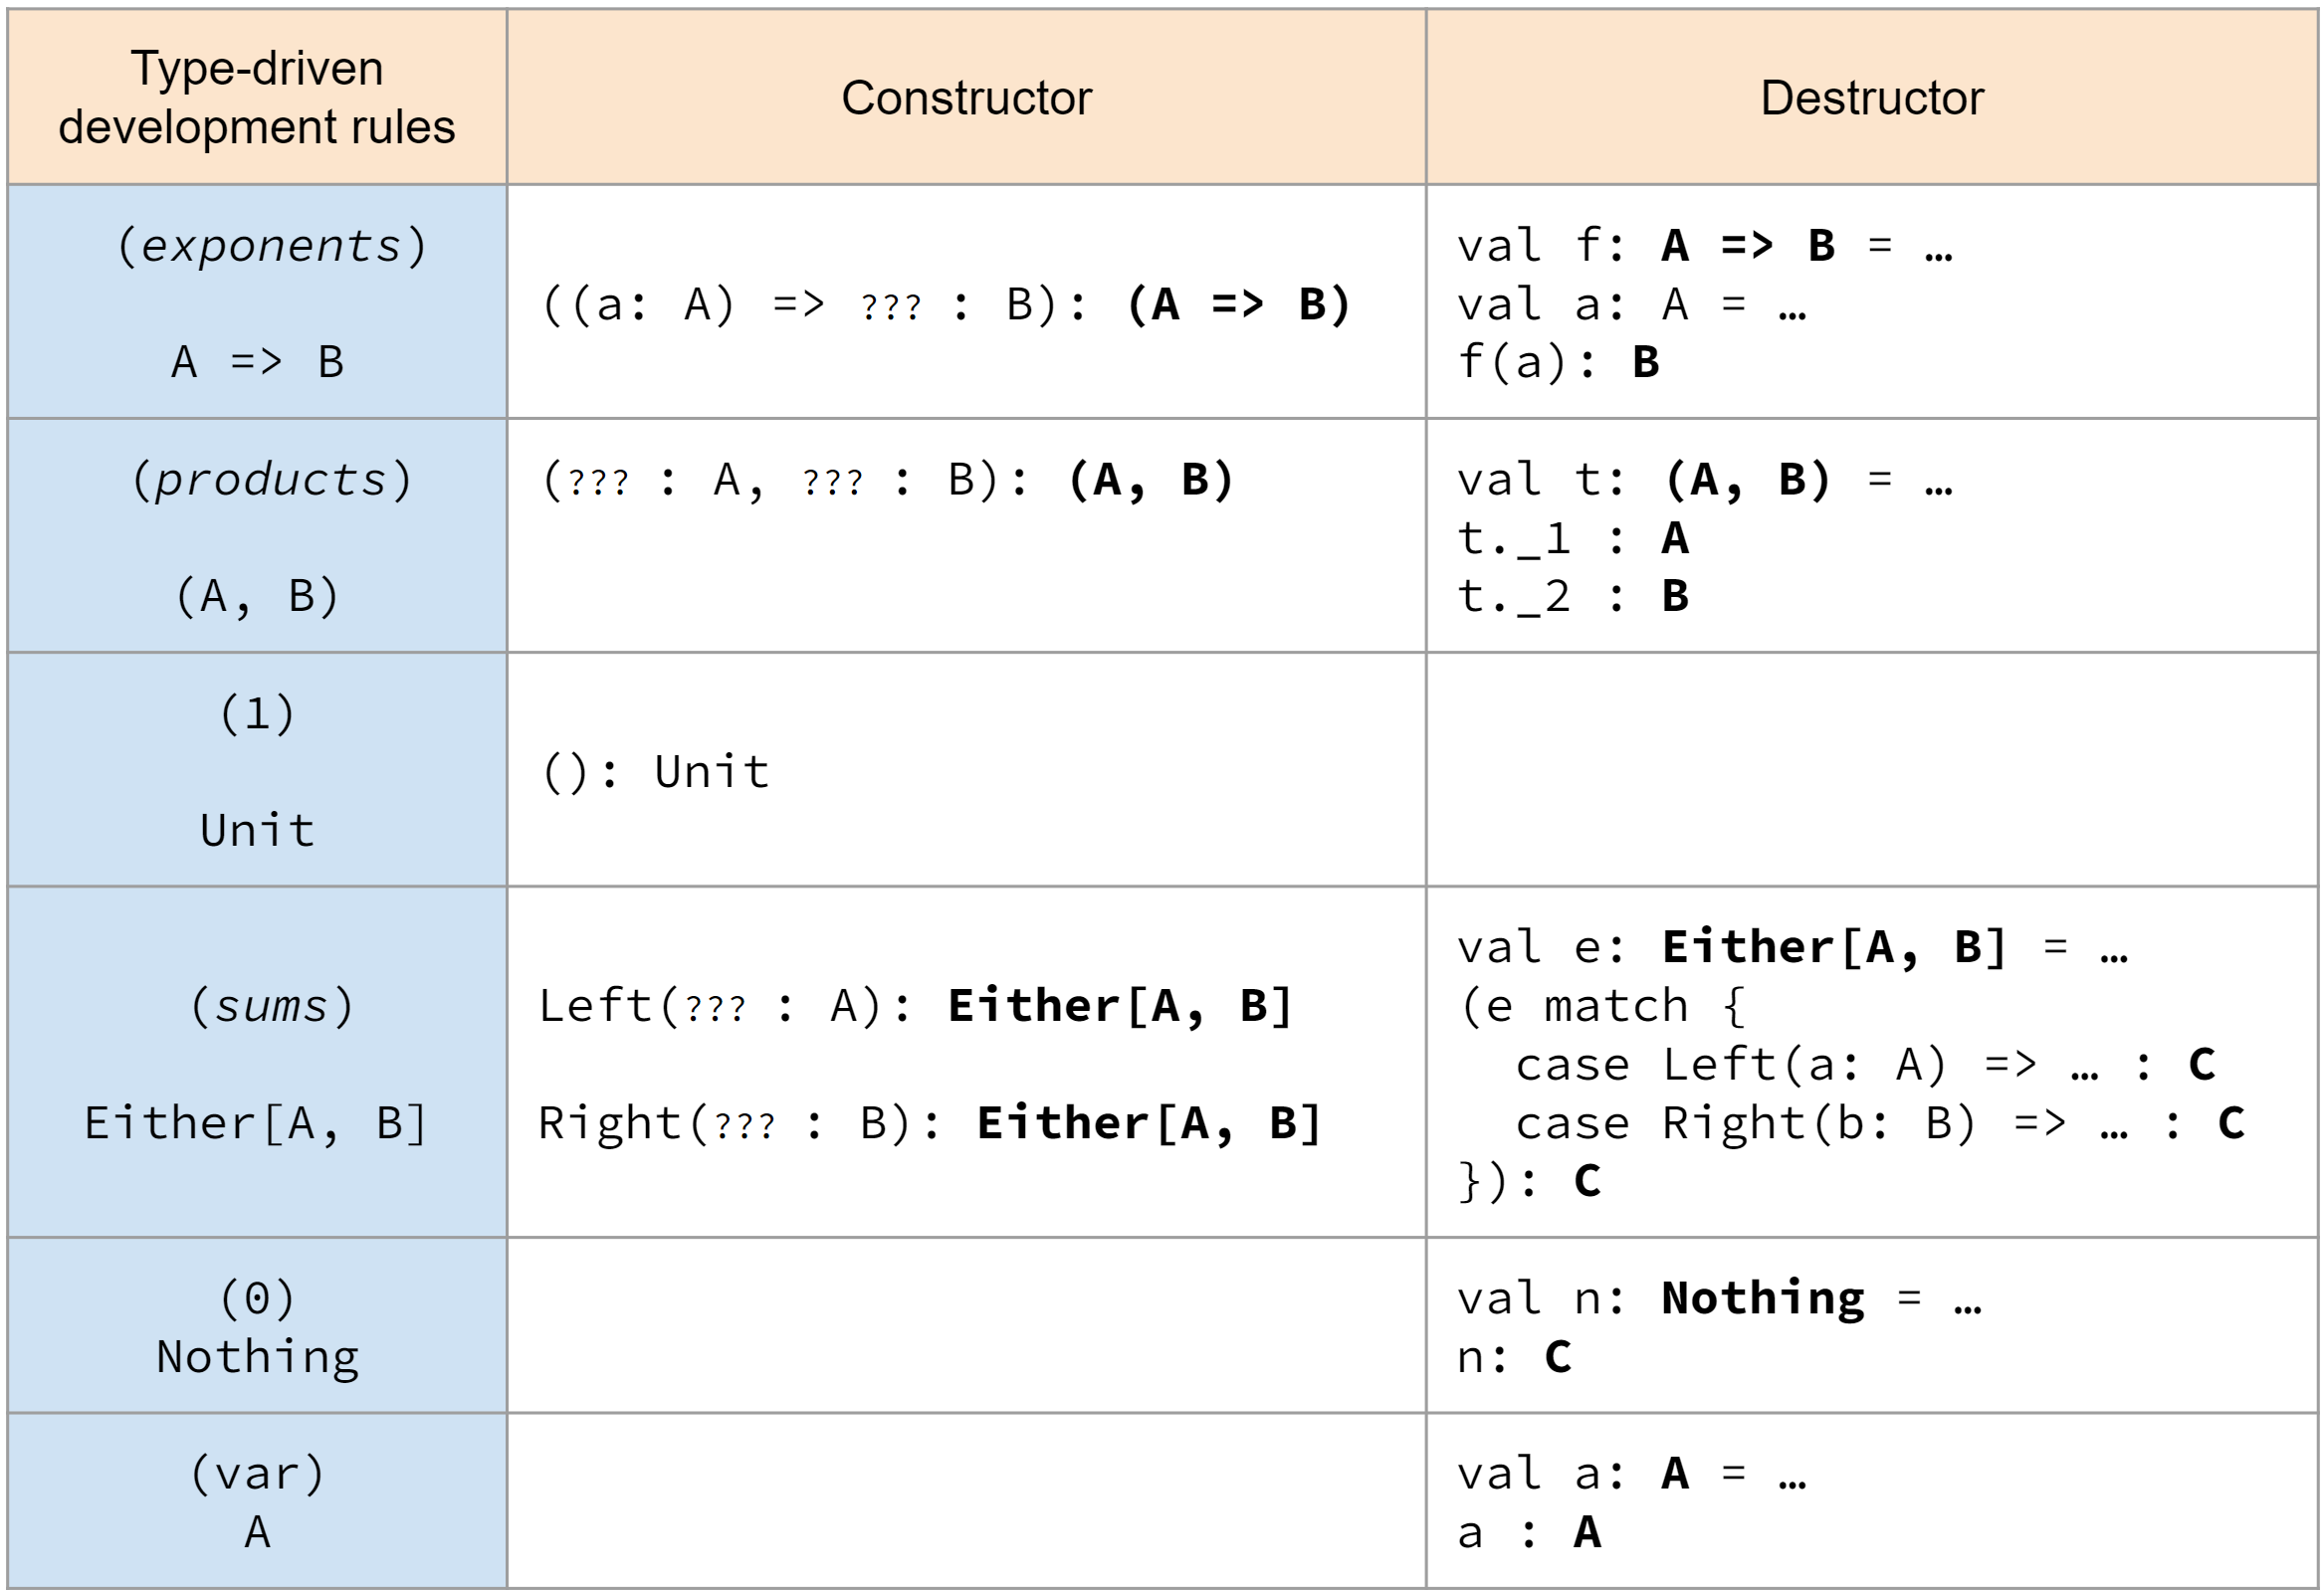

In [ ]:
type Not[P] = P => Nothing
type <=>[P, Q] = (P => Q, Q => P)

In [ ]:
trait ExcludedMiddle: 
    def apply[P]: Either[P, Not[P]]

In [ ]:
trait DoubleNegation:
    def apply[P]: Not[Not[P]] => P

# Ejercicio 1
__(2 puntos)__

__a) (1 punto)__ Utiliza la correspondencia de Curry-Howard para demostrar la siguiente tautología de la lógica proposicional intuicionista:

##### $\vdash ((q \rightarrow r) \rightarrow p \rightarrow q) \rightarrow (r \rightarrow s) \rightarrow ((p \rightarrow q) \rightarrow r) \rightarrow s$

In [ ]:
def proof[P, Q, R, S]: ((Q => R) => P => Q) => (R => S) => ((P => Q) => R) => S = 
    f => g => h => 
        g(h(f((q: Q) => h(_ => q))))

__b) (1 punto)__ Se desea utilizar la correspondencia de Curry-Howard para demostrar la validez de la siguiente tautología de la lógica clásica proposicional: 

##### $\vdash (p \rightarrow q \vee r) \rightarrow (p \rightarrow q) \vee (p \rightarrow r)$

Para ello, utiliza como premisa adicional la ley del tercio excluso aplicada a la proposición $r$.

In [ ]:
def proof[P, Q, R](lem: ExcludedMiddle): (P => Either[Q, R]) => Either[P => Q, P => R] = 
    f => lem[R] match 
        case Left(r) => Right(_ => r)
        case Right(nr) => 
            Left: p => 
                f(p) match 
                    case Left(q) => q
                    case Right(r) => nr(r)

# Ejercicio 2
__(1 punto)__

Demuestra que, para cualesquiera tipos `A`, `B`, `C` y `D` los tipos de datos `(A Either B Either C) => D` y `(A => D, B => D, C => D)` son isomorfos. Para ello, se deberá instanciar la plantilla `Isomorphic` que se encuentra en el preámbulo del examen.

In [ ]:
class Iso[A, B, C, D] extends Isomorphic[(A Either B Either C) => D, (A => D, B => D, C => D)]:

    def from(t: (A Either B Either C) => D): (A => D, B => D, C => D) =
        (a => t(Left(Left(a))), b => t(Left(Right(b))), c => t(Right(c)))

    def to(t: (A => D, B => D, C => D)): (A Either B Either C) => D =
        case Left(Left(a)) => t._1(a)
        case Left(Right(b)) => t._2(b)
        case Right(c) => t._3(c)

# Ejercicio 3
__(3 puntos)__

Se desea implementar una función `decode` que traduzca números romanos a sus equivalentes en notación decimal. Por ejemplo, la función deberá satisfacer los siguientes tests: 

In [ ]:
class TestDecode(decode: String => Int) extends AnyFlatSpec with should.Matchers:
    
    "decode" should "work" in:
        decode("IX") shouldBe 9
        decode("XIV")    shouldBe 14
        decode("XLII")   shouldBe 42
        decode("LXXXIX") shouldBe 89
        decode("CXL")    shouldBe 140
        decode("MCM")    shouldBe 1900
        decode("MCMXXIV") shouldBe 1924
        decode("MCMLXXXIV") shouldBe 1984
        decode("MMXXIV") shouldBe 2024

Asumiendo que la cadena de caracteres recibida como entrada representa un número romano válido, el proceso de traducción se puede descomponer en los pasos descritos por el siguiente diagrama:  

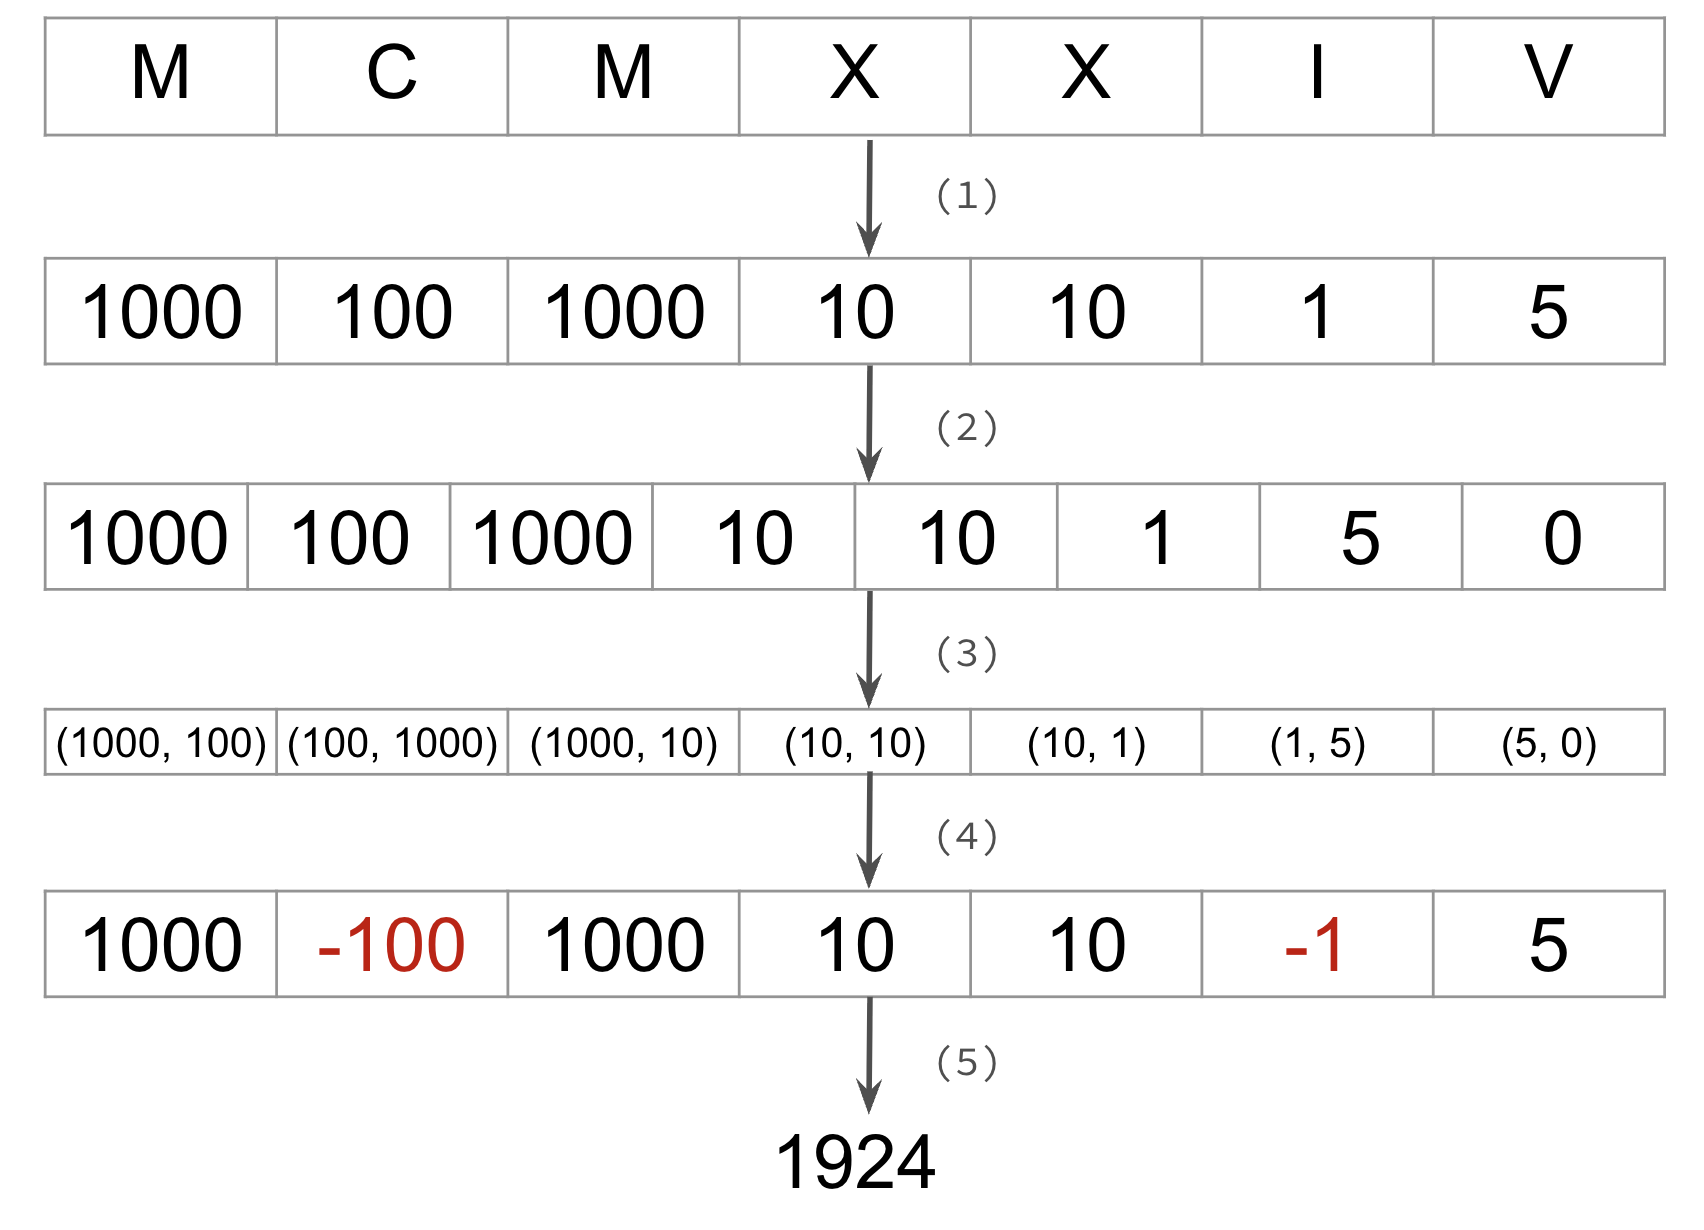

(1) En primer lugar, se traducen los símbolos romanos a números decimales, siguiendo el esquema de traducción descrito por la siguiente función:

In [ ]:
val Sym: Char => Int = 
    case 'I' => 1
    case 'V' => 5
    case 'X' => 10
    case 'L' => 50
    case 'C' => 100
    case 'D' => 500
    case 'M' => 1000

En ciertas situaciones, la suma de los números resultantes de esta traducción consiste en el resultado correcto. Por ejemplo, la traducción de "MDXXIII" es 1523 = 1000 + 5000 + 10 + 10 + 1 + 1 +1. En otras ocasiones, sin embargo, en lugar de sumar el número decimal obtenido en la traducción de un símbolo, hay que restarlo. Esto sucede cuando el número decimal es menor que el que se encuentra justo a continuación, lo cual sucede en el ejemplo de la figura para los números 100 y 1. Para ajustar correctamente los números de la traducción antes de proceder a su suma se siguen los siguientes pasos: 

(2) Añadimos un 0 a la lista de números decimales.

(3) Creamos una nueva lista de pares de números formados por cada número y su siguiente.

(4) Ajustamos el signo del primer dígito del par de acuerdo a lo comentado anteriormente.

(5) Sumamos los dígitos.

Para implementar la función siguiendo este esquema de procesamiento se tienen disponibles, además de las funciones de orden superior habituales estudiadas durante el curso, las funciones sobre listas de la librería estándar de Scala `appended`, `sliding` y `reduce`. Obsérvese que el resultado de la función `sliding` es un objeto del tipo `Iterator[List[A]]`, no del tipo `List[List[A]]`. Para realizar la conversión a listas se puede utilizar el método `toList` de la siguiente forma:  

In [ ]:
List(1,2,3,4,5).sliding(3).toList

Asimismo, téngase en cuenta que una cadena de caracteres se puede convertir a una lista mediante el método `toList`: 

In [ ]:
"MCMXXIV".toList == List('M', 'C', 'M', 'X', 'X', 'I', 'V')

__a) (1 punto)__ Implementa la función `adjust` que recibe una lista de al menos dos números enteros y devuelve el primero de ellos con el signo ajustado de acuerdo a la especificación anterior.

In [ ]:
class TestAdjust(adjust: List[Int] => Int) extends AnyFlatSpec with should.Matchers:
    
    "adjust" should "work" in:
        adjust(List(100,10)) shouldBe 100
        adjust(List(500, 1)) shouldBe 500
        adjust(List(10, 50)) shouldBe -10
        adjust(List(100, 10000)) shouldBe -100

In [ ]:
// IMPLEMENTA TU RESPUESTA

val adjust: List[Int] => Int = 
    case List(e1, e2) if e1 < e2 => -e1
    case List(e1, _) => e1    

In [ ]:
run(TestAdjust(adjust))

__b) (2 puntos)__ Implementa la función `decode` declarativamente, de acuerdo con el esquema de traducción descrito anteriormente. 

In [ ]:
// INTRODUCE TU RESPUESTA

// En una implementación idiomática no se utilizaría el método toList, 
// dado que la función map se puede aplicar directamente al String,
// y los iteradores proporcionan igualmente las funciones map y reduce

def decode(r: String): Int = 
    r.toList
     .map(Sym)           // (1)
     .appended(0)        // (2)
     .sliding(2).toList  // (3)
     .map(adjust)        // (4)
     .reduce(_ + _)      // (5)

In [ ]:
run(TestDecode(decode))

# Ejercicio 4
__(4 puntos)__

El problema de la decodificación de números romanos se puede resolver también en base a un patrón de diseño iterativo. Para ello, en cada paso de la iteración, además de la solución parcial construida hasta el momento, tenemos que tener en cuenta el número previo. Por ejemplo, considérese la siguiente iteración para traducir el número "MCMXXIV":

|(res, prev)       | aux                                     |
|------------------|-----------------------------------------|
| (0, None)        | List('M', 'C', 'M', 'X', 'X', 'I', 'V') |
| (0, Some(1000))  |      List('C', 'M', 'X', 'X', 'I', 'V') |
| (1000, Some(100))|           List('M', 'X', 'X', 'I', 'V') |
| (900, Some(1000))|                List('X', 'X', 'I', 'V') |
| (1900, Some(10)) |                     List('X', 'I', 'V') |
| (1910, Some(10)) |                          List('I', 'V') |
| (1920, Some(1))  |                               List('V') |
| (1019, Some(5))  |                                  List() |
| 1019+5           |                                         |

El primer paso de la iteración comienza con la solución parcial `(0, None)`, es decir, la suma parcial hasta el momento es 0, y no tenemos ningún elemento previo. La actualización de la solución parcial en este primer paso consiste únicamente en actualizar el valor previo con la traducción del primer símbolo de la lista restante. En los siguientes pasos, se compara el valor previo y el primer símbolo de la lista restante y si es menor se resta de la suma parcial; en otro caso, se suma. Finalmente, cuando termina la iteración solo queda agregar el elemento previo a la suma parcial para obtener el resultado buscado.

_Nota_: La descripción anterior no encaja exactamente con el pseudocódigo explicado en clase para la implementación de algoritmos por recursión final. Según este esquema, incluido en el preámbulo del examen, el tipo de la solución parcial actualizada en cada paso de la iteración es precisamente el tipo de valores que devuelve la función. En nuestro caso, sin embargo, la "solución parcial" que se inicializa y se actualiza en cada paso de la iteración es una tupla `(Int, Option[Int])`, mientras que el valor que tiene que devolver la función es un `Int`. Los cambios a realizar en el pseudocódigo, no obstante, son pequeños: simplemente hay que realizar un post-procesamiento del resultado de la función `step`. 

__a) (2 puntos)__ Implementa la función `decode` mediante un patrón de diseño iterativo utilizando recursión final. 

In [ ]:
// IMPLEMENTA TU RESPUESTA

def decode(s: String): Int = 

    def step(out: (Option[Int], Int), aux: List[Char]): (Option[Int], Int) = 
        (out, aux) match 
            case (out, Nil) => out
            case ((None, res), head :: tail) => 
                step((Some(Sym(head)), res), tail)
            case ((Some(prev), res), head :: tail) if prev < Sym(head) => 
                step((Some(Sym(head)), res - prev), tail)
            case ((Some(prev), res), head :: tail) => 
                step((Some(Sym(head)), res + prev), tail)

    step((None, 0), s.toList) match 
        case (None, e) => e
        case (Some(e1), e2) => e1 + e2

In [ ]:
run(TestDecode(decode))

__b) (2 puntos)__ Implementa el algoritmo iterativo mediante la función de orden superior `foldLeft`. 

In [ ]:
// IMPLEMENTA TU RESPUESTA

def decode(s: String): Int = 
    s.toList.foldLeft(None: Option[Int], 0): 
        case ((None, res), head) => 
            (Some(Sym(head)), res)
        case ((Some(prev), res), head) if prev < Sym(head) => 
            (Some(Sym(head)), res - prev)
        case ((Some(prev), res), head) => 
            (Some(Sym(head)), res + prev)
    match 
        case (None, e) => e
        case (Some(e1), e2) => e1 + e2

In [ ]:
run(TestDecode(decode))